I0 (on-axis) = 2.803e+17 W/m^2
 Layer k  r_in (mm)  r_out (mm)  t_k (mm)  B_avg (check)
       1   0.000000    1.697056  0.101378        4.19894
       2   1.697056    2.400000  0.145308        4.19894
       3   2.400000    2.939388  0.208274        4.19894
       4   2.939388    3.394113  0.298525        4.19894
       5   3.394113    3.794733  0.427885        4.19894
       6   3.794733    4.156922  0.613300        4.19894
       7   4.156922    4.489989  0.879061        4.19894
       8   4.489989    4.800000  1.259984        4.19894

Wrote (original): intensity_radial.png, intensity_temporal.png, intensity_map.png,
                    film_thickness_targetB6.png, film_Br_targetB6.png,
                    film_phase.png, film_time_delay.png, film_layers_targetB6.csv


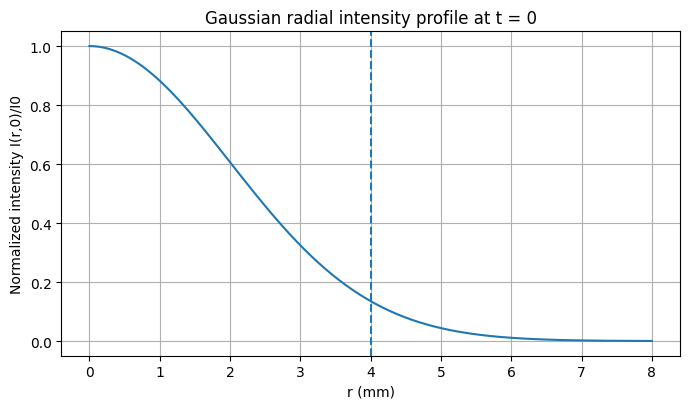

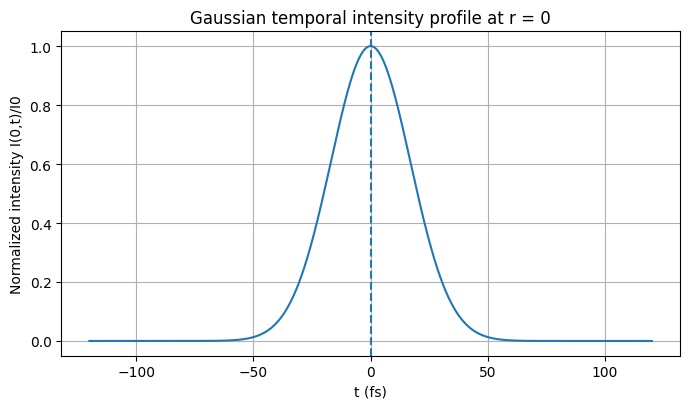

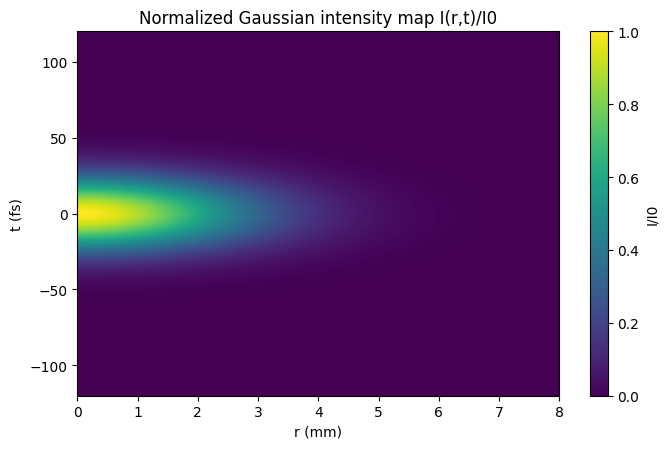

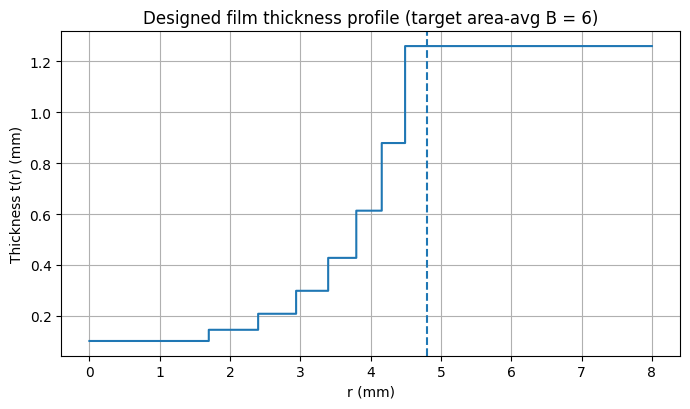

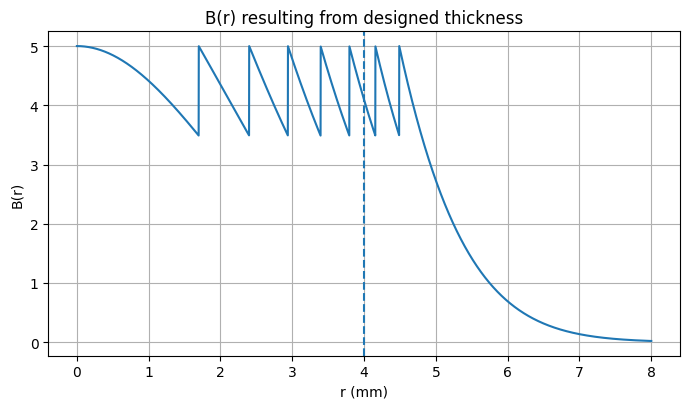

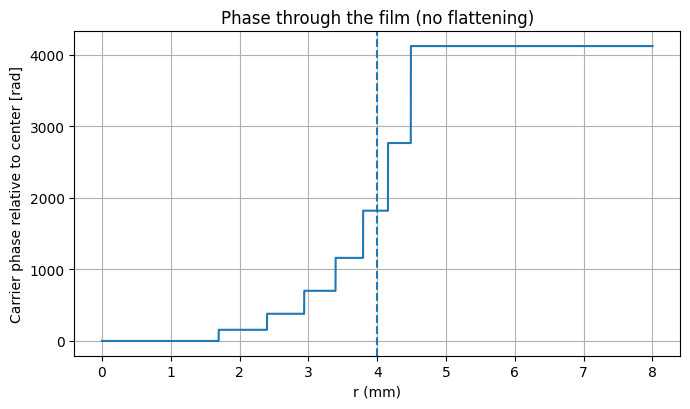

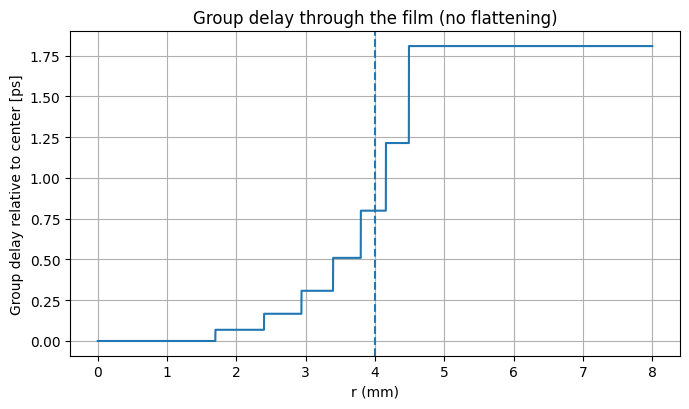

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Background & Objectives (Overview)
----------------------------------
Background:
- Ultrashort laser pulse: energy E = 1000 mJ, intensity FWHM τ = 40 fs, center wavelength λ = 800 nm; transverse profile is Gaussian with 1/e² radius w = 4 mm.
- Design a transmissive echelon film. Split the aperture r ≤ w into 10 equal-width annular rings and set the film thickness per ring so that the area-averaged B-integral hits B_tar = 6. Outside (w < r ≤ 2w) the film is kept at a constant thickness for a smooth process transition.
- B-integral definition: B = (2π/λ) · n₂ · I_avg · t, where I_avg is the ring’s area-averaged intensity and t is the ring thickness.
- Phase flattening: after meeting B, allow a per-ring thickness tweak |Δt| ≤ λ/(2n) to align the carrier phase (mod 2π) of all rings to the center with negligible change to B.
- Reflective echelon mirror: use geometric path 2d/c to introduce group delay that cancels the film’s group delay. Under a tight group-delay tolerance, also make the total carrier phase as flat as possible.

Objectives:
1) Starting from the Gaussian I(r, t), back-solve the first film thickness per ring so the area-averaged B ≈ 6.
2) Phase-flatten the film: per-ring tweak within ±λ/(2n) to align the carrier phase (mod 2π).
3) Design a reflective echelon mirror that drives the combined residual group delay |Δτ| ≤ 0.1 fs; subject to that, maximize carrier-phase flatness.
4) Provide analytic delay–phase tradeoffs and a closed-form co-design (film + mirror) solution. Include mirror step quantization and a tiny film correction so residual phase is near zero while |Δτ| ≤ 0.1 fs.

Key relations (first-order, small updates):
- Film thickness only (Δt):  Δτ = (n_g/c)·Δt,  Δφ = (2π/λ)·n·Δt  ⇒  Δφ/Δτ = (2πc/λ)·(n/n_g) ≈ 2.3305 rad/fs (with this script’s parameters).
- Mirror height only (Δd, double pass):  Δτ = (2/c)·Δd,  Δφ = (4π/λ)·Δd  ⇒  Δφ/Δτ = (2πc/λ) ≈ 2.3546 rad/fs.
- Zero-phase-increment co-design for a prescribed Δτ:  choose  Δt = c·Δτ/(n_g − n),  Δd = −(n/2)·Δt.

Workflow (Sections 1–11):
1–7) Compute/visualize I(r, t) → area-averaged equal-B film (10 rings) → verification plots.
8) Phase flattening (±λ/2n): output flattened t(r), B(r), Δτ(r), and φ(r).
9) Reflective echelon: `mirror_mode='gd_first'` quantizes step heights by group-delay tolerance (not λ/2) to reach |Δτ| ≤ 0.1 fs; `'phase_neutral'` (λ/2 quantization) is available for comparison.
10) Analytic film+mirror co-design: closed-form updates with mirror quantization and tiny film compensation to keep Δτ within tolerance while flattening phase.
11) Final manufacturing profiles for both components with per-ring tables.

Defaults & conventions:
- Indices: n = 1.453, n_g = 1.468; Kerr n₂ = 2.24×10⁻²⁰ m²/W; λ = 800 nm; E = 0.1 J; τ = 40 fs; w = 4 mm; target B_tar = 6; ring_count = 10.
- Group-delay tolerance gd_tol_fs = 0.1 fs; mirror mode `mirror_mode='gd_first'`; allow tiny post-mirror film tweak `allow_fine_film_tweak=True`.
- Units: internal SI; plots label r in mm and time in fs/ps.

Outputs: see per-section comments and printouts (figures/CSVs for I(r,t), t(r), B(r), Δτ, φ in original, flattened, mirrored, co-designed, and final manufacturing forms).


Notes
-----
- This script covers only the *first film* design and phase-flattening. No mirror.
- Units are SI internally; plots label r in mm and t in fs/ps for readability.
"""
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# -----------------------------
# 0) Constants & parameters
# -----------------------------
@dataclass
class Params:
    c: float = 299_792_458.0          # m/s
    lam: float = 800e-9               # m (center wavelength)
    n: float = 1.453                  # phase index @ 800 nm
    ng: float = 1.468                 # group index @ 800 nm
    n2: float = 2.24e-20              # m^2/W (fused silica Kerr)
    E: float = 0.300                     # J  (100 mJ)
    tau: float = 40e-15               # s  (intensity FWHM)
    w: float = 4e-3                   # m  (1/e^2 radius)
    B_tar: float = 5.0                # target area-avg B=6 per ring
    ring_count: int =8              # number of annular rings in 0..w =11 
    r_pts: int = 1201                 # samples for I(r) & intensity map
    t_pts: int = 1201                 # samples for I(t) & intensity map
    design_radius_factor: float = 1.2

P = Params()

# -----------------------------
# 1) Peak intensity for separable Gaussian
# -----------------------------
# I(r,t) = I0 * exp(-2 r^2/w^2) * exp(-4 ln2 * t^2/tau^2)
# Energy E constrains I0:
# I0 = (4 sqrt(ln2) / pi^(3/2)) * E / (w^2 * tau)
I0 = (4*np.sqrt(np.log(2)) / (np.pi**1.5)) * P.E / (P.w**2 * P.tau)

# Radial/temporal grids for visualization
r_max = 2*P.w
r = np.linspace(0.0, r_max, P.r_pts)             # m
t_window = 6*P.tau                               # ±3*tau covers >99%
t = np.linspace(-0.5*t_window, 0.5*t_window, P.t_pts)  # s

# Factorized profiles (used for quick 1D checks)
I_r = I0 * np.exp(-2.0*(r**2)/(P.w**2))          # I(r,0)
I_t = I0 * np.exp(-4.0*np.log(2.0)*(t**2)/(P.tau**2))  # I(0,t)
# 2D distribution for image (outer product of normalized 1D profiles)
I_rt = np.outer(I_r/I0, I_t/I0) * I0             # W/m^2

# -----------------------------
# 2) Partition into rings and compute thicknesses for B_tar
#    —— 自适应等面积分环 + 峰值不超标（用内边强度定厚度）
# -----------------------------
B_const = (2.0*np.pi/P.lam) * P.n2

# 等面积分环：r_k = w * sqrt(k/N)
N = P.ring_count
R_design_m = P.design_radius_factor * P.w   
edges_m = R_design_m * np.sqrt(np.linspace(0.0, 1.0, N+1))

def area_avg_intensity_annulus(I0: float, w: float, r0: float, r1: float) -> float:
    a = 2.0/(w**2)
    delta_exp = np.exp(-a*(r0**2)) - np.exp(-a*(r1**2))
    return I0 * ((w**2/2.0)*delta_exp) / ( (r1**2 - r0**2) )

layers = []
t_layers_m = []
for k in range(N):
    r0, r1 = edges_m[k], edges_m[k+1]
    # 峰值出现在环内最大强度处（高斯单调递减 → 内边 r0），对于第一环则在 r=0 处
    I_inner = I0 * np.exp(-2.0*(r0**2)/(P.w**2))
    # 令 B_peak = B_tar：B_const * I_inner * t_k = B_tar
    t_k = P.B_tar / (B_const * I_inner)
    t_layers_m.append(t_k)

    # 计算面积平均强度（用于核对 B_avg，不影响设计）
    I_avg = area_avg_intensity_annulus(I0, P.w, r0, r1)
    B_avg_check = B_const * I_avg * t_k  # 会 <= B_tar

    layers.append({
        "Layer k": k+1,
        "r_in (mm)": 1e3*r0,
        "r_out (mm)": 1e3*r1,
        "I_inner / I0": I_inner/I0,
        "I_avg / I0": I_avg/I0,
        "t_k (mm)": 1e3*t_k,
        "B_avg (check)": B_avg_check  # 保持原列名，避免 KeyError
    })

# Constant thickness outside r>w equals the outer ring thickness (smooth transition)
t_layers_m = np.array(t_layers_m, dtype=float)
t_const_m  = t_layers_m[-1]

# -----------------------------
# 3) Build stepwise radial thickness profile on 0..2w
# -----------------------------
r_mm_dense = np.linspace(0.0, 2*1e3*P.w, 4001)
t_mm_dense = np.empty_like(r_mm_dense)
inside = r_mm_dense <= 1e3*R_design_m   

# map each r to its ring index
edges_mm = 1e3*edges_m
idx = np.digitize(r_mm_dense[inside], edges_mm) - 1
idx = np.clip(idx, 0, len(t_layers_m)-1)
t_mm_dense[inside]  = 1e3*t_layers_m[idx]
t_mm_dense[~inside] = 1e3*t_const_m

# -----------------------------
# 4) Verification: pointwise B(r) and B(r) plot
# -----------------------------
I_r_dense = I0 * np.exp(-2.0*((1e-3*r_mm_dense)**2)/(P.w**2))
B_r_dense = B_const * I_r_dense * (1e-3*t_mm_dense)

# -----------------------------
# 5) Phase and group delay through the film (relative to center)
# -----------------------------
# Build a meters-thickness profile again for convenience
t_profile_m = np.empty_like(r_mm_dense) * 1e-3
t_profile_m[inside]  = t_layers_m[idx]
t_profile_m[~inside] = t_const_m

# Relative thickness to center (ring 1)
delta_t_m = t_profile_m - t_layers_m[0]
phi_rel = (2*np.pi/P.lam) * (P.n - 1.0) * delta_t_m        # radians (unchanged)

# >>> FIX: include the air propagation after the film (group delay uses ng - ng_air)
ng_air = 1.0
GD_rel_s  = ((P.ng - ng_air)/P.c) * delta_t_m        # seconds

# -----------------------------
# 6) Save CSV table (original design)
# -----------------------------
df_layers = pd.DataFrame(layers)
df_layers.to_csv("film_layers_targetB6.csv", index=False)

# -----------------------------
# 7) Plots for the original (un-flattened) design
# -----------------------------
# (A) Radial profile I(r,0)
plt.figure(figsize=(7,4.2))
plt.plot(1e3*r, I_r/I0)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Normalized intensity I(r,0)/I0")
plt.title("Gaussian radial intensity profile at t = 0")
plt.grid(True)
plt.tight_layout()
plt.savefig("intensity_radial.png", dpi=180)

# (B) Temporal profile I(0,t)
plt.figure(figsize=(7,4.2))
plt.plot(1e15*t, I_t/I0)
plt.axvline(0.0, linestyle='--')
plt.xlabel("t (fs)")
plt.ylabel("Normalized intensity I(0,t)/I0")
plt.title("Gaussian temporal intensity profile at r = 0")
plt.grid(True)
plt.tight_layout()
plt.savefig("intensity_temporal.png", dpi=180)

# (C) 2D intensity map (normalized)
plt.figure(figsize=(7,4.6))
extent=[1e3*r.min(), 1e3*r.max(), 1e15*t.min(), 1e15*t.max()]
plt.imshow((I_rt/I0).T, aspect='auto', origin='lower', extent=extent)
plt.xlabel("r (mm)")
plt.ylabel("t (fs)")
plt.title("Normalized Gaussian intensity map I(r,t)/I0")
plt.colorbar(label="I/I0")
plt.tight_layout()
plt.savefig("intensity_map.png", dpi=180)

# (D) Designed film thickness profile
plt.figure(figsize=(7,4.2))
plt.step(r_mm_dense, t_mm_dense, where='post')
plt.axvline(1e3*R_design_m, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Thickness t(r) (mm)")
plt.title("Designed film thickness profile (target area-avg B = 6)")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_thickness_targetB6.png", dpi=180)

# (E) B(r) for verification
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, B_r_dense)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("B(r)")
plt.title("B(r) resulting from designed thickness")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_Br_targetB6.png", dpi=180)

# (F) Phase through the film (relative to center)
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, phi_rel)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Carrier phase relative to center [rad]")
plt.title("Phase through the film (no flattening)")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_phase.png", dpi=180)

# (G) Group delay through the film (relative to center)
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, 1e12*GD_rel_s)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Group delay relative to center [ps]")
plt.title("Group delay through the film (no flattening)")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_time_delay.png", dpi=180)

print(f"I0 (on-axis) = {I0:.3e} W/m^2")
print(df_layers[["Layer k","r_in (mm)","r_out (mm)","t_k (mm)","B_avg (check)"]].to_string(index=False))
print("\nWrote (original): intensity_radial.png, intensity_temporal.png, intensity_map.png,"
      "\n                    film_thickness_targetB6.png, film_Br_targetB6.png,"
      "\n                    film_phase.png, film_time_delay.png, film_layers_targetB6.csv")



(Phase‑flattening) Wrote: film_thickness_phase_flattened.png, film_Br_phase_flattened.png,
                            film_time_delay_phase_flattened.png, film_phase_flattened_wrapped.png,
                            film_phase_flatten_deltat_nm.png, film_layers_phase_flattened.csv


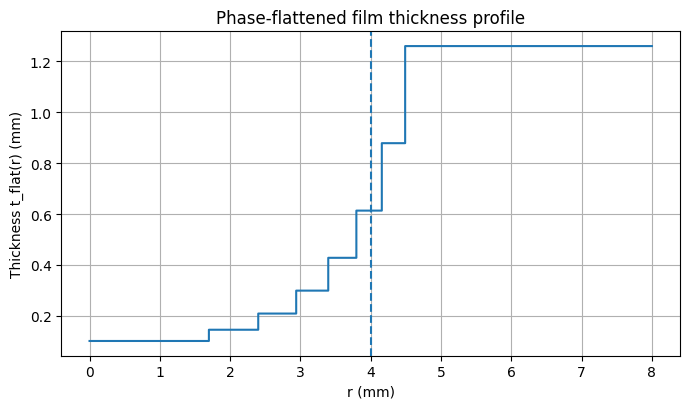

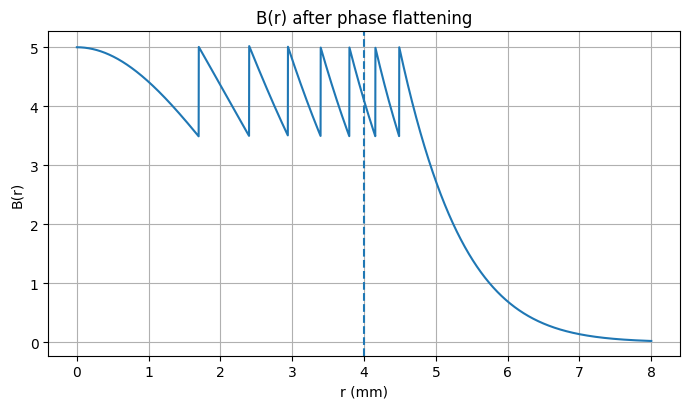

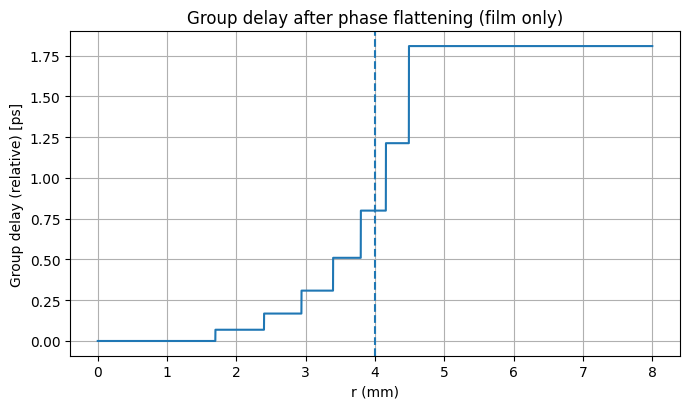

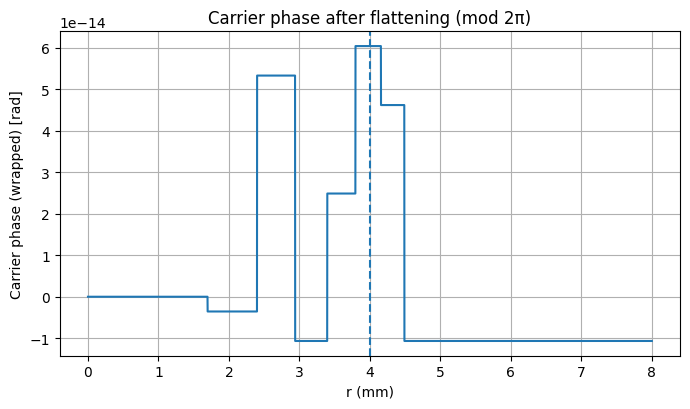

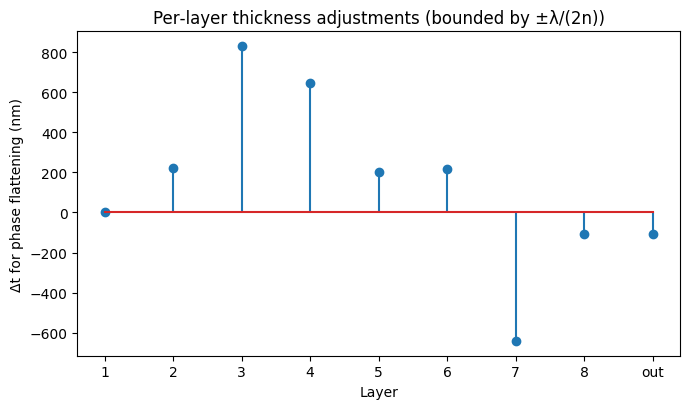

In [2]:
# ============================================================
# 8) Phase‑flattening: per‑laye r Δt within ±λ/(2n), added to original thickness
#     Goal: carrier phase (mod 2π) aligned across rings relative to the center.
#     We *only* modify thickness (no mirror here). New plots are saved without
#     overwriting the originals.
#     NOTE: phase is now referenced to AIR (common output plane): use (n - 1).
# ============================================================
def wrap_pi(phi: np.ndarray) -> np.ndarray:
    return (phi + np.pi) % (2*np.pi) - np.pi

# --- Phase wrt common plane (AIR reference): use (n - 1) ---
# Per‑layer relative phase to center before flattening
phi_layer = (2*np.pi/P.lam) * (P.n - 1.0) * (t_layers_m - t_layers_m[0])

# Thickness per radian of phase (AIR‑referenced) and bound ±λ/(2n)
d_wrap = P.lam / (2*np.pi * (P.n - 1.0))   # thickness per rad of phase (AIR)
dt_bound = P.lam / (2.0 * P.n)*4             # keep your original ±λ/(2n) limit

# Ideal Δt from wrapped phase, then CLIP to ±λ/(2n) to keep the original bound
Delta_t_layers_m = - d_wrap * wrap_pi(phi_layer)
Delta_t_layers_m = np.clip(Delta_t_layers_m, -dt_bound, dt_bound)   # meters

# Apply corrections to each ring; also correct the outer constant region so that
# r = w boundary is mod‑2π continuous relative to the center (under same bound).
t_layers_flat_m = t_layers_m + Delta_t_layers_m

phi_const = (2*np.pi/P.lam) * (P.n - 1.0) * (t_const_m - t_layers_m[0])
Delta_t_const_m = - d_wrap * wrap_pi(phi_const)
Delta_t_const_m = np.clip(Delta_t_const_m, -dt_bound, dt_bound)
t_const_flat_m  = t_const_m + Delta_t_const_m

# Build flattened radial profile on 0..2w
t_flat_mm = np.empty_like(r_mm_dense)
t_flat_mm[inside]  = 1e3*t_layers_flat_m[idx]
t_flat_mm[~inside] = 1e3*t_const_flat_m

# B(r) after flattening (point intensity)
B_r_flat = B_const * I_r_dense * (1e-3*t_flat_mm)

# Group delay & phase after flattening (relative to center; AIR reference)
t_flat_m = 1e-3*t_flat_mm
Delta_t_center_m = t_layers_flat_m[0]
Delta_t_flat_m = t_flat_m - Delta_t_center_m

GD_flat_s = ((P.ng - 1.0)/P.c) * Delta_t_flat_m
phi_flat_wrapped = wrap_pi((2*np.pi/P.lam) * (P.n - 1.0) * Delta_t_flat_m)

# Per‑layer table after flattening
rows_flat = []
for k in range(P.ring_count):
    r0 = edges_m[k]; r1 = edges_m[k+1]
    # area‑avg intensity for the ring
    I_avg = area_avg_intensity_annulus(I0, P.w, r0, r1)
    B_avg_flat = B_const * I_avg * t_layers_flat_m[k]
    rows_flat.append({
        "Layer k": k+1,
        "r range (mm)": f"{1e3*r0:.1f}–{1e3*r1:.1f}",
        "t_orig (mm)": 1e3*t_layers_m[k],
        "Δt_flatten (nm)": 1e9*Delta_t_layers_m[k],
        "t_flat (mm)": 1e3*t_layers_flat_m[k],
        "B_avg (flat)": B_avg_flat,
    })
# Append outer region row
rows_flat.append({
    "Layer k": "const(out)",
    "r range (mm)": f"{1e3*P.w:.1f}–{2*1e3*P.w:.1f}",
    "t_orig (mm)": 1e3*t_const_m,
    "Δt_flatten (nm)": 1e9*(t_const_flat_m - t_const_m),
    "t_flat (mm)": 1e3*t_const_flat_m,
    "B_avg (flat)": None,
})

df_flat = pd.DataFrame(rows_flat)
df_flat.to_csv("film_layers_phase_flattened.csv", index=False)

# --------- Plots (flattened) ---------
# (H) Flattened thickness profile
plt.figure(figsize=(7,4.2))
plt.step(r_mm_dense, t_flat_mm, where='post')
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Thickness t_flat(r) (mm)")
plt.title("Phase‑flattened film thickness profile")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_thickness_phase_flattened.png", dpi=180)

# (I) B(r) after flattening
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, B_r_flat)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("B(r)")
plt.title("B(r) after phase flattening")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_Br_phase_flattened.png", dpi=180)

# (J) Group delay after flattening
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, 1e12*GD_flat_s)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Group delay (relative) [ps]")
plt.title("Group delay after phase flattening (film only)")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_time_delay_phase_flattened.png", dpi=180)

# (K) Carrier phase (wrapped) after flattening
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, phi_flat_wrapped)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Carrier phase (wrapped) [rad]")
plt.title("Carrier phase after flattening (mod 2π)")
plt.grid(True)
plt.tight_layout()
plt.savefig("film_phase_flattened_wrapped.png", dpi=180)

# (L) Per‑layer Δt bar chart (no special kwargs for broad compat)
plt.figure(figsize=(7,4.2))
X = list(map(str, range(1, P.ring_count+1))) + ["out"]
Y = list(1e9*Delta_t_layers_m) + [1e9*(t_const_flat_m - t_const_m)]
plt.stem(range(len(X)), Y)
plt.xticks(range(len(X)), X)
plt.xlabel("Layer")
plt.ylabel("Δt for phase flattening (nm)")
plt.title("Per‑layer thickness adjustments (bounded by ±λ/(2n))")
plt.tight_layout()
plt.savefig("film_phase_flatten_deltat_nm.png", dpi=180)

print("\n(Phase‑flattening) Wrote: film_thickness_phase_flattened.png, film_Br_phase_flattened.png,"
      "\n                            film_time_delay_phase_flattened.png, film_phase_flattened_wrapped.png,"
      "\n                            film_phase_flatten_deltat_nm.png, film_layers_phase_flattened.csv")


(Step 9 - GD-cancel only) Wrote: step9_residual_delay_fs.png, step9_phase_after_mirror_wrapped.png, step9_exact_gd_cancel_mirror.csv


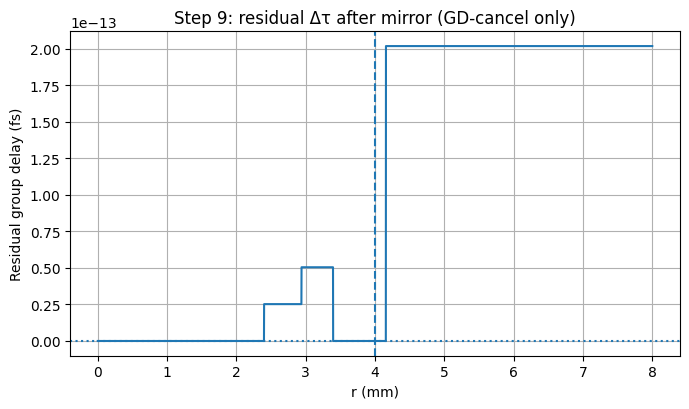

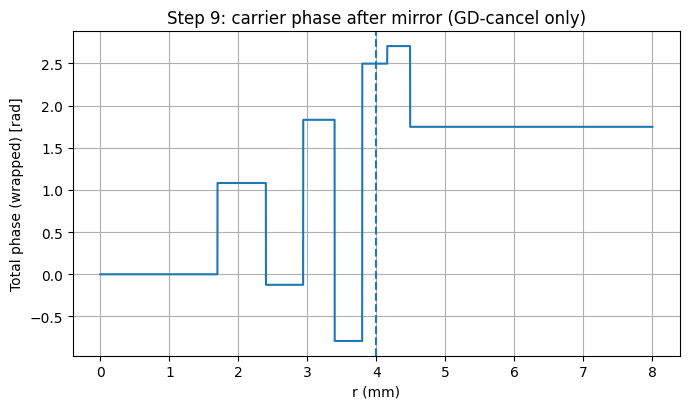

In [3]:
# ============================================================
# 9) Reflective echelon (GD-cancel ONLY, no film change, no phase concern)
#     Inputs (from Step 8):
#       - Delta_t_flat_m   : film thickness relative to center (after phase-flattening in Step 8)
#       - GD_flat_s        : film-only group delay relative to center (Step 8)
#       - r_mm_dense, edges_mm, inside, idx, P, wrap_pi
#     Goal:
#       Choose mirror heights (relative to center) to cancel GD exactly:
#         ((ng - 1)/c) * Δt  +  (2/c) * d_rel  = 0
#         =>  d_rel = - ((ng - 1)/2) * Δt
#     Outputs:
#       - Plots: residual GD after mirror (fs),
#                total carrier phase after mirror (wrapped) [rad]
#       - CSV:   per-radius values for verification
#     Notes:
#       - This step DOES NOT modify the film.
#       - For downstream compatibility with Steps 10/11, we set:
#           Delta_t_flat_tweaked_m = Delta_t_flat_m
#           d_rel_q_m  = d_rel_cont_m (no quantization here)
#           phi_total_final_wrapped = phi_total_after_mirror_wrapped
#           GD_total_final_s        = GD_total_after_mirror_s
# ============================================================

# --- Safety checks & compatibility shims ---
try:
    Delta_t_flat_m
    GD_flat_s
except NameError as e:
    raise RuntimeError("Step 9 (GD-cancel mirror) requires Step 8 outputs: "
                       "Delta_t_flat_m and GD_flat_s.") from e

# Downstream code expects a 'tweaked' film; here we make it identical to Step 8
Delta_t_flat_tweaked_m = Delta_t_flat_m.copy()

# Sensitivities (AIR reference, consistent with Step 8)
k_tau_t = (P.ng - 1.0) / P.c            # s/m (film GD)
k_tau_d = 2.0 / P.c                     # s/m (mirror GD, double pass)
k_phi_t = (2.0*np.pi / P.lam) * (P.n - 1.0)  # rad/m (film PHASE)
k_phi_d = (4.0*np.pi / P.lam)                # rad/m (mirror PHASE, double pass)

# --- 9.1 Ideal mirror (relative-to-center) that cancels GD exactly ---
# Δτ_total = k_tau_t * Δt  +  k_tau_d * d_rel  ≡ 0
# => d_rel_cont = - (k_tau_t/k_tau_d) * Δt = - ((ng - 1)/2) * Δt
d_rel_cont_m = - ((P.ng - 1.0) / 2.0) * Delta_t_flat_m

# Absolute mirror height for fabrication (shift so min height >= 0)
mirror_offset_m = -np.min(d_rel_cont_m)
d_abs_m = d_rel_cont_m + mirror_offset_m

# --- 9.2 Delays and phases AFTER mirror (film unchanged) ---
GD_mirror_s = k_tau_d * d_rel_cont_m
GD_total_after_mirror_s = GD_flat_s + GD_mirror_s   # ≈ 0 (up to numerical noise)

phi_mirror = k_phi_d * d_rel_cont_m
phi_total_after_mirror_wrapped = wrap_pi(k_phi_t * Delta_t_flat_m + phi_mirror)

# --- 9.3 Save CSV for verification (dense radius) ---
df_step9 = pd.DataFrame({
    "r_mm": r_mm_dense,
    "Delta_t_film_rel_um": 1e6 * Delta_t_flat_m,
    "d_mirror_rel_um":     1e6 * d_rel_cont_m,
    "d_mirror_abs_um":     1e6 * d_abs_m,
    "GD_film_fs":          1e15 * GD_flat_s,
    "GD_mirror_fs":        1e15 * GD_mirror_s,
    "GD_total_fs":         1e15 * GD_total_after_mirror_s,
    "phi_total_wrapped_rad": phi_total_after_mirror_wrapped,
})
df_step9.to_csv("step9_exact_gd_cancel_mirror.csv", index=False)

# --- 9.4 Plots: residual GD & total phase (after mirror) ---
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, 1e15*GD_total_after_mirror_s)
plt.axhline(0.0, linestyle=':')
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Residual group delay (fs)")
plt.title("Step 9: residual Δτ after mirror (GD-cancel only)")
plt.grid(True)
plt.tight_layout()
plt.savefig("step9_residual_delay_fs.png", dpi=180)

plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, phi_total_after_mirror_wrapped)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Total phase (wrapped) [rad]")
plt.title("Step 9: carrier phase after mirror (GD-cancel only)")
plt.grid(True)
plt.tight_layout()
plt.savefig("step9_phase_after_mirror_wrapped.png", dpi=180)

print("(Step 9 - GD-cancel only) Wrote:",
      "step9_residual_delay_fs.png, step9_phase_after_mirror_wrapped.png,",
      "step9_exact_gd_cancel_mirror.csv")

# --- 9.5 Downstream compatibility aliases (for Steps 10/11 if needed) ---
# Keep the same variable names as in the original pipeline:
d_rel_q_m = d_rel_cont_m                              # no quantization; but reuse the name
GD_total_final_s = GD_total_after_mirror_s            # mirror after; no fine film tweak in this step
phi_total_final_wrapped = phi_total_after_mirror_wrapped


[Mirror-only phase flatten] RMS|Δd_abs| = 72.85 nm, Max|Δd_abs| = 161.59 nm
(Step 10 • mirror-only) Wrote: mirror_only_phase_flatten_gd.png, mirror_only_phase_flatten_phase_wrapped.png, mirror_phase_only_flatten_layers.csv


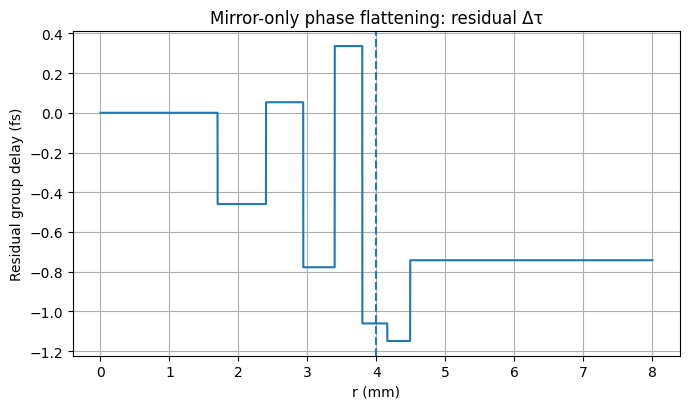

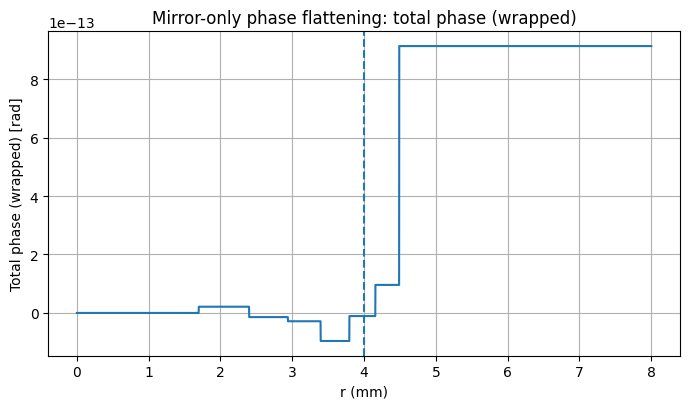

In [4]:
# ============================================================
# 10) Mirror-only micro-adjustment for phase-flattening (NO GD targeting)
#     - Keep the film unchanged.
#     - Adjust mirror heights by the minimal amounts that flatten total carrier
#       phase (mod 2π) across radius.
#     - Then REPORT (not optimize) the resulting GD after this phase flatten.
#     Inputs assumed from Step 9: 
#       r_mm_dense, inside, idx, edges_mm, P, wrap_pi
#       Delta_t_flat_tweaked_m (film rel. center), d_rel_q_m (mirror rel.), d_abs_m (mirror abs)
#       phi_total_final_wrapped (total phase after step 9, wrapped)
# ============================================================

# --- Safety checks ---
required_vars = [
    'r_mm_dense','inside','idx','edges_mm','P','wrap_pi',
    'Delta_t_flat_tweaked_m','d_rel_q_m','d_abs_m','phi_total_final_wrapped'
]
for _v in required_vars:
    if _v not in globals():
        raise RuntimeError(f"Step 10 requires variable '{_v}' from Steps 8–9.")

# Sensitivities (AIR-referenced, consistent with Steps 8–9)
k_tau_t = (P.ng - 1.0)/P.c           # s/m (film GD)
k_tau_d = 2.0/P.c                    # s/m (mirror GD, double pass)
k_phi_t = (2.0*np.pi/P.lam)*(P.n-1.) # rad/m (film PHASE)
k_phi_d = (4.0*np.pi/P.lam)          # rad/m (mirror PHASE, double pass)

# --- 10.1 Compute minimal mirror correction that nulls phase (mod 2π) ---
# Dense, radius-by-radius correction (relative heights). Use wrapped φ ⇒ minimal |Δd|
dd_corr_rel_dense_m = - phi_total_final_wrapped / k_phi_d

# Anchor to center (keep "relative to center" convention exact)
dd_corr_rel_dense_m = dd_corr_rel_dense_m - dd_corr_rel_dense_m[0]

# Make a ringwise step correction profile (constant within each annulus; outer region constant)
dd_corr_layers_m = np.zeros(P.ring_count)
for k in range(P.ring_count):
    r_mid = 0.5*(edges_mm[k] + edges_mm[k+1])
    j = np.searchsorted(r_mm_dense, r_mid)
    j = min(j, len(r_mm_dense)-1)
    dd_corr_layers_m[k] = dd_corr_rel_dense_m[j]

dd_corr_profile_m = np.empty_like(r_mm_dense)
dd_corr_profile_m[inside]  = dd_corr_layers_m[idx]
dd_corr_profile_m[~inside] = dd_corr_layers_m[-1]

# New mirror (relative-to-center) after mirror-only phase flatten
d_rel_phaseflat_m = d_rel_q_m + dd_corr_profile_m

# Choose an absolute offset to minimize overall absolute change vs existing d_abs_m (L2-optimal),
# then ensure non-negative heights for fabrication.
alpha_l2 = np.mean(d_abs_m - d_rel_phaseflat_m)       # minimizes ||(d_rel_phaseflat+α) - d_abs||
d_abs_phaseflat_m = d_rel_phaseflat_m + alpha_l2
min_h = np.min(d_abs_phaseflat_m)
if min_h < 0:
    d_abs_phaseflat_m -= min_h                         # shift up to keep ≥ 0

# Diagnostics: how small are the required mirror changes (absolute, for fab delta)?
dd_adjust_abs_m = d_abs_phaseflat_m - d_abs_m
dd_adj_rms_nm   = 1e9*np.sqrt(np.mean(dd_adjust_abs_m**2))
dd_adj_max_nm   = 1e9*np.max(np.abs(dd_adjust_abs_m))
print(f"[Mirror-only phase flatten] RMS|Δd_abs| = {dd_adj_rms_nm:.2f} nm, "
      f"Max|Δd_abs| = {dd_adj_max_nm:.2f} nm")

# --- 10.2 Totals after mirror-only phase flatten (film unchanged) ---
GD_total_phaseflat_s   = k_tau_t*Delta_t_flat_tweaked_m + k_tau_d*d_rel_phaseflat_m
phi_total_phaseflat_wr = wrap_pi(k_phi_t*Delta_t_flat_tweaked_m + k_phi_d*d_rel_phaseflat_m)

# --- 10.3 Export per-ring summary (optional but handy) ---
rows_mirror_phaseonly = []
for k in range(P.ring_count):
    r0, r1 = edges_mm[k], edges_mm[k+1]
    r_mid  = 0.5*(r0+r1)
    j = np.searchsorted(r_mm_dense, r_mid)
    j = min(j, len(r_mm_dense)-1)
    rows_mirror_phaseonly.append({
        "Layer k": k+1,
        "r range (mm)": f"{r0:.1f}–{r1:.1f}",
        "Δd_rel for phase (nm)": 1e9*dd_corr_layers_m[k],
        "d_abs adjust (nm)": 1e9*(d_abs_phaseflat_m[j]-d_abs_m[j]),
        "φ_total (wrapped rad)": phi_total_phaseflat_wr[j],
        "Δτ_total (fs)": 1e15*GD_total_phaseflat_s[j],
    })
pd.DataFrame(rows_mirror_phaseonly).to_csv("mirror_phase_only_flatten_layers.csv", index=False)

## --- 10.4 Two separate figures: residual GD and total phase (wrapped) ---

# (A) Residual GD only
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, 1e15*GD_total_phaseflat_s)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Residual group delay (fs)")
plt.title("Mirror-only phase flattening: residual Δτ")
plt.grid(True)
plt.tight_layout()
plt.savefig("mirror_only_phase_flatten_gd.png", dpi=180)

# (B) Total phase (wrapped) only
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, phi_total_phaseflat_wr)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Total phase (wrapped) [rad]")
plt.title("Mirror-only phase flattening: total phase (wrapped)")
plt.grid(True)
plt.tight_layout()
plt.savefig("mirror_only_phase_flatten_phase_wrapped.png", dpi=180)

print("(Step 10 • mirror-only) Wrote: mirror_only_phase_flatten_gd.png, "
      "mirror_only_phase_flatten_phase_wrapped.png, mirror_phase_only_flatten_layers.csv")


[Step 11] GD step per phase-neutral pair: 0.0884 fs (guaranteed residual ≤ 0.0442 fs by nearest-integer pairing).
[Step 11] Max|τ_after| = 0.0353 fs (target ≤ 0.0442 fs).
[Step 11] RMS φ_after (wrapped) = 6.0603e-13 rad
(Step 11) Wrote: step11_gd_trimmed.png, step11_total_phase_wrapped.png, step11_phase_neutral_gd_trim_layers.csv
(Step 11) Max |ΔB(r)| = 0.304
(Step 11) Wrote: step11_B_integral_before_after.png
(Step 11) Film Δthickness max = 22958.1 nm; Mirror Δheight max = 4800.0 nm
(Step 11) Wrote: step11_film_mirror_thickness_before_after.png
(Step 11) Saved files:
  - step11_phase_neutral_gd_trim_layers.csv
  - step11_gd_trimmed.png
  - step11_total_phase_wrapped.png
  - step11_film_mirror_thickness_before_after.png
  - step11_B_integral_before_after.png
  - step11_profiles_film_mirror_radial.csv
  - step11_film_profile_radial.csv
  - step11_mirror_profile_radial.csv
  - step11_layers_film_mirror_abs.csv


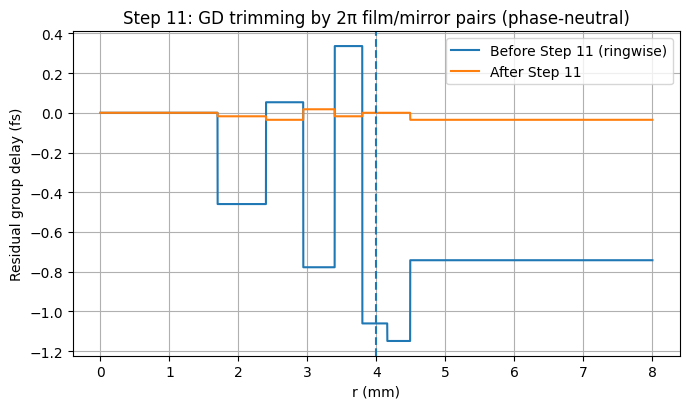

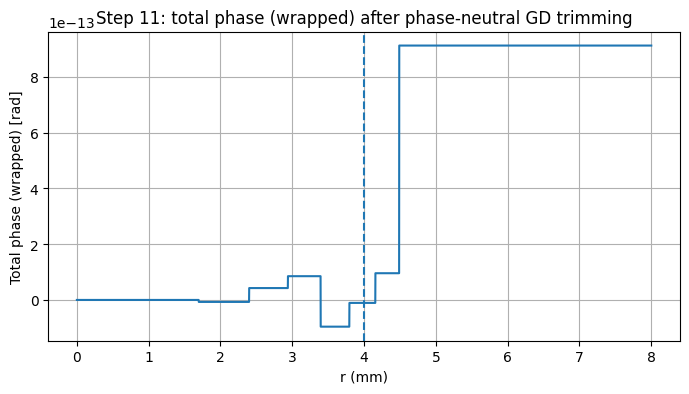

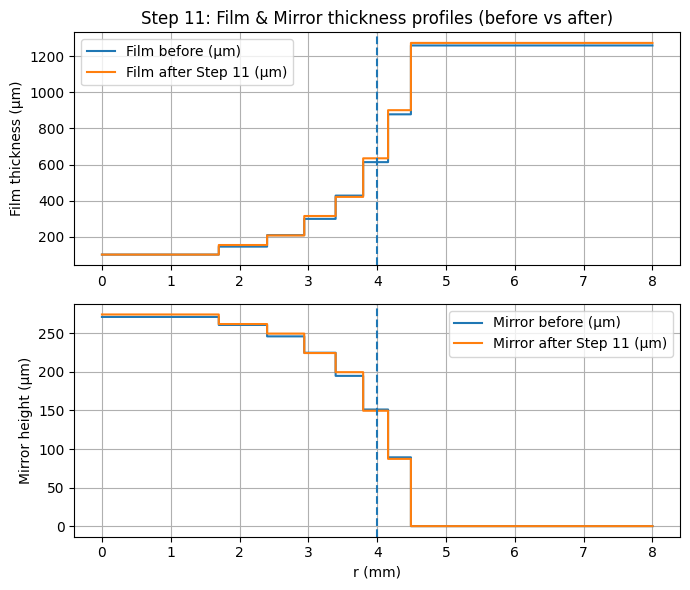

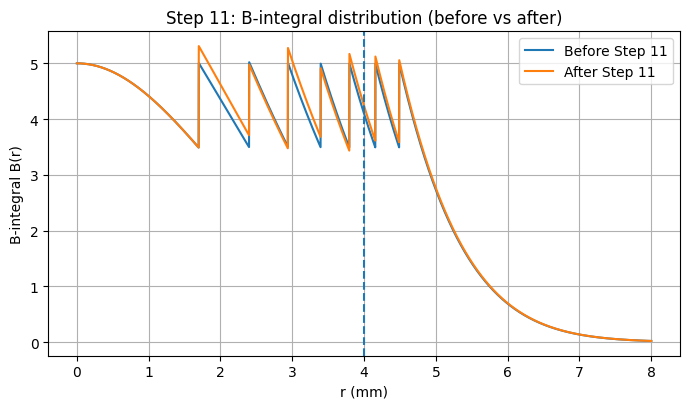

In [5]:
# ============================================================
# 11) Phase-neutral GD trimming by 2π film/mirror pairs
#     - Keep total phase flat (mod 2π) by pairing: film ±2π  & mirror ∓2π
#     - Minimize residual GD per ring via nearest-integer pairing
#     Inputs assumed from Step 10:
#       GD_total_phaseflat_s, phi_total_phaseflat_wr, Delta_t_flat_tweaked_m,
#       d_rel_phaseflat_m, d_abs_phaseflat_m,
#       r_mm_dense, inside, idx, edges_mm, P, wrap_pi
# ============================================================

# --- Safety checks (ensure Step 10 outputs exist) ---
required_vars = [
    'GD_total_phaseflat_s','phi_total_phaseflat_wr','Delta_t_flat_tweaked_m',
    'd_rel_phaseflat_m','d_abs_phaseflat_m','r_mm_dense','inside','idx','edges_mm','P','wrap_pi'
]
for _v in required_vars:
    if _v not in globals():
        raise RuntimeError(f"Step 11 requires variable '{_v}' from Step 10.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sensitivities (AIR-reference)
k_tau_t = (P.ng - 1.0)/P.c           # s/m (film GD)
k_tau_d = 2.0/P.c                    # s/m (mirror GD, double pass)
k_phi_t = (2.0*np.pi/P.lam)*(P.n-1.) # rad/m (film PHASE)
k_phi_d = (4.0*np.pi/P.lam)          # rad/m (mirror PHASE, double pass)

# One "phase-neutral pair" (film +2π, mirror −2π):
dt_step_m = P.lam/(P.n - 1.0)   # film thickness per +2π
dd_step_m = -P.lam/2.0          # mirror height per −2π
# Corresponding GD step (total, phase-neutral):
tau_pair_s = (P.lam/P.c)*((P.ng - 1.0)/(P.n - 1.0) - 1.0)  # >0 for fused silica @ 800 nm
tau_pair_fs = 1e15 * tau_pair_s
print(f"[Step 11] GD step per phase-neutral pair: {tau_pair_fs:.4f} fs "
      f"(guaranteed residual ≤ {tau_pair_fs/2:.4f} fs by nearest-integer pairing).")

# ---- Decide integer steps per ring (using ring midpoints) ----
m_layers = np.zeros(P.ring_count, dtype=int)
tau_before_layers_fs = np.zeros(P.ring_count)
for k in range(P.ring_count):
    r_mid = 0.5*(edges_mm[k] + edges_mm[k+1])
    j = np.searchsorted(r_mm_dense, r_mid)
    j = min(j, len(r_mm_dense)-1)
    tau_before_layers_fs[k] = 1e15*GD_total_phaseflat_s[j]
    # choose m so that tau_after ≈ tau_before + m*tau_pair is closest to 0
    m_layers[k] = int(np.rint(- tau_before_layers_fs[k] / tau_pair_fs))

# ---- Build ringwise increments (film & mirror), anchor to center (relative profiles) ----
dt_pair_layers_m = m_layers * dt_step_m          # film change per ring (absolute per ring)
dd_pair_layers_m = m_layers * dd_step_m          # mirror change per ring (absolute per ring)

# relative-to-center increments (to keep "Δ relative to center" convention)
dt_pair_layers_rel_m = dt_pair_layers_m - dt_pair_layers_m[0]
dd_pair_layers_rel_m = dd_pair_layers_m - dd_pair_layers_m[0]

# Map to dense radius (0..2w); outer region = outer ring value
dt_pair_profile_rel_m = np.empty_like(r_mm_dense)
dd_pair_profile_rel_m = np.empty_like(r_mm_dense)
dt_pair_profile_rel_m[inside]  = dt_pair_layers_rel_m[idx]
dt_pair_profile_rel_m[~inside] = dt_pair_layers_rel_m[-1]
dd_pair_profile_rel_m[inside]  = dd_pair_layers_rel_m[idx]
dd_pair_profile_rel_m[~inside] = dd_pair_layers_rel_m[-1]

# ---- Apply to film (relative Δt) and mirror (relative Δd) ----
Delta_t_step11_m = Delta_t_flat_tweaked_m + dt_pair_profile_rel_m
d_rel_step11_m   = d_rel_phaseflat_m   + dd_pair_profile_rel_m

# (Optionally update absolute mirror height for fab deltas)
d_abs_step11_m = d_rel_step11_m + np.mean(d_abs_phaseflat_m - d_rel_step11_m)
min_h = np.min(d_abs_step11_m)
if min_h < 0:
    d_abs_step11_m -= min_h  # keep ≥0

# ---- Totals after Step 11 ----
GD_total_step11_s   = k_tau_t*Delta_t_step11_m + k_tau_d*d_rel_step11_m
phi_total_step11_wr = wrap_pi(k_phi_t*Delta_t_step11_m + k_phi_d*d_rel_step11_m)

# ---- Per-ring report ----
rows_step11 = []
for k in range(P.ring_count):
    r0, r1 = edges_mm[k], edges_mm[k+1]
    r_mid = 0.5*(r0+r1)
    j = np.searchsorted(r_mm_dense, r_mid)
    j = min(j, len(r_mm_dense)-1)
    rows_step11.append({
        "Layer k": k+1,
        "r range (mm)": f"{r0:.1f}–{r1:.1f}",
        "m (pairs)": int(m_layers[k]),
        "τ_before (fs)": tau_before_layers_fs[k],
        "τ_after (fs)": 1e15*GD_total_step11_s[j],
        "Δt_film (µm)": 1e6*dt_pair_layers_m[k],
        "Δd_mirror (µm)": 1e6*dd_pair_layers_m[k],
        "φ_after (wrapped rad)": phi_total_step11_wr[j],
    })
pd.DataFrame(rows_step11).to_csv("step11_phase_neutral_gd_trim_layers.csv", index=False)

# ---- Summary & checks ----
tau_after_fs = 1e15*GD_total_step11_s
phi_after_wr = phi_total_step11_wr
print(f"[Step 11] Max|τ_after| = {np.max(np.abs(tau_after_fs)):.4f} fs "
      f"(target ≤ {tau_pair_fs/2:.4f} fs).")
print(f"[Step 11] RMS φ_after (wrapped) = {np.sqrt(np.mean(phi_after_wr**2)):.4e} rad")

# Build dense baseline GD (fs) from ringwise values for 0..2w
tau_before_dense_fs = np.empty_like(r_mm_dense)  # same length as r_mm_dense
tau_before_dense_fs[inside]  = tau_before_layers_fs[idx]     # map rings to r ≤ w
tau_before_dense_fs[~inside] = tau_before_layers_fs[-1]      # outside: use outer ring value

# ---- Plots: separate GD and phase (as in Step 10 style) ----
plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, tau_before_dense_fs, label="Before Step 11 (ringwise)")
plt.plot(r_mm_dense, tau_after_fs, label="After Step 11")
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("Residual group delay (fs)")
plt.title("Step 11: GD trimming by 2π film/mirror pairs (phase-neutral)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("step11_gd_trimmed.png", dpi=180)

plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, phi_total_step11_wr)
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)"); plt.ylabel("Total phase (wrapped) [rad]")
plt.title("Step 11: total phase (wrapped) after phase-neutral GD trimming")
plt.grid(True); plt.tight_layout()
plt.savefig("step11_total_phase_wrapped.png", dpi=180)

print("(Step 11) Wrote: step11_gd_trimmed.png, step11_total_phase_wrapped.png, "
      "step11_phase_neutral_gd_trim_layers.csv")

# --- Step 11 extra: BEFORE vs AFTER thickness/height profiles (film & mirror) ---

# Build film absolute thickness BEFORE Step 11 robustly
def _rebuild_film_before_abs_m():
    # Prefer the explicit radial profile from Step 8 if present
    if 't_flat_mm' in globals():
        return 1e-3 * t_flat_mm  # mm -> m
    # Or rebuild from ringwise arrays from Step 8 if available
    if ('t_layers_flat_m' in globals()) and ('t_const_flat_m' in globals()):
        arr = np.empty_like(r_mm_dense)
        arr[inside]  = t_layers_flat_m[idx]
        arr[~inside] = t_const_flat_m
        return arr
    # Fallback: use relative profile + center thickness if available
    t0 = None
    if 't_layers_flat_m' in globals():
        t0 = t_layers_flat_m[0]
    if t0 is None:
        t0 = 0.0  # last-resort fallback (absolute offset won't affect relative GD/phase)
        print("[Step 11] Warning: using zero-offset fallback for film absolute thickness.")
    return (Delta_t_flat_tweaked_m - Delta_t_flat_tweaked_m[0]) + t0

t_film_before_m = _rebuild_film_before_abs_m()

# Film absolute thickness AFTER Step 11 (center-anchored relative increment)
t_film_after_m  = t_film_before_m + dt_pair_profile_rel_m

# Mirror absolute height BEFORE/AFTER
d_mirror_before_m = d_abs_phaseflat_m   # from Step 10 (mirror-only phase flatten)
d_mirror_after_m  = d_abs_step11_m      # Step 11 updated absolute mirror

# Plot
plt.figure(figsize=(7,6))
# (1) Film
plt.subplot(2,1,1)
plt.step(r_mm_dense, 1e6*t_film_before_m, where='post', label='Film before (µm)')
plt.step(r_mm_dense, 1e6*t_film_after_m,  where='post', label='Film after Step 11 (µm)')
plt.axvline(1e3*P.w, linestyle='--')
plt.ylabel('Film thickness (µm)')
plt.title('Step 11: Film & Mirror thickness profiles (before vs after)')
plt.grid(True)
plt.legend()

# (2) Mirror
plt.subplot(2,1,2)
plt.step(r_mm_dense, 1e6*d_mirror_before_m, where='post', label='Mirror before (µm)')
plt.step(r_mm_dense, 1e6*d_mirror_after_m,  where='post', label='Mirror after Step 11 (µm)')
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel('r (mm)')
plt.ylabel('Mirror height (µm)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("step11_film_mirror_thickness_before_after.png", dpi=180)

# --- Step 11 extra: B-integral distribution BEFORE vs AFTER (pointwise, t=0) ---

# Ensure intensity and B-constant exist (rebuild if needed)
if 'B_const' not in globals():
    B_const = (2.0*np.pi/P.lam) * P.n2
if 'I_r_dense' not in globals():
    # rebuild I0 and I_r_dense if not present
    if 'I0' not in globals():
        I0 = (4*np.sqrt(np.log(2)) / (np.pi**1.5)) * P.E / (P.w**2 * P.tau)
    r_m_dense = 1e-3 * r_mm_dense
    I_r_dense = I0 * np.exp(-2.0*(r_m_dense**2)/(P.w**2))

# B(r) = (2π/λ) n2 I(r,0) t(r)
B_before = B_const * I_r_dense * t_film_before_m
B_after  = B_const * I_r_dense * t_film_after_m

plt.figure(figsize=(7,4.2))
plt.plot(r_mm_dense, B_before, label="Before Step 11")
plt.plot(r_mm_dense, B_after,  label="After Step 11")
plt.axvline(1e3*P.w, linestyle='--')
plt.xlabel("r (mm)")
plt.ylabel("B-integral B(r)")
plt.title("Step 11: B-integral distribution (before vs after)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("step11_B_integral_before_after.png", dpi=180)

# quick summary
print(f"(Step 11) Max |ΔB(r)| = {np.max(np.abs(B_after - B_before)):.3f}")
print("(Step 11) Wrote: step11_B_integral_before_after.png")

# Quick deltas summary
print(f"(Step 11) Film Δthickness max = {1e9*np.max(np.abs(t_film_after_m - t_film_before_m)):.1f} nm; "
      f"Mirror Δheight max = {1e9*np.max(np.abs(d_mirror_after_m - d_mirror_before_m)):.1f} nm")
print("(Step 11) Wrote: step11_film_mirror_thickness_before_after.png")

# === Step 11 • Save final film/mirror thickness/height profiles (radial & per-ring) ===
# 依赖：t_film_before_m, t_film_after_m, d_mirror_before_m, d_abs_step11_m, r_mm_dense, edges_mm, P

# 若 edges_m 不在作用域（常见于只保留 mm 变量的情况），做个兜底：
try:
    edges_m
except NameError:
    edges_m = 1e-3 * edges_mm  # mm -> m

# 1) 径向剖面（0..2w），便于制造/仿真调用
pd.DataFrame({
    "r_mm": r_mm_dense,
    "film_before_mm": 1e3 * t_film_before_m,
    "film_after_mm":  1e3 * t_film_after_m,
    "mirror_before_um": 1e6 * d_mirror_before_m,
    "mirror_after_um":  1e6 * d_abs_step11_m,
}).to_csv("step11_profiles_film_mirror_radial.csv", index=False)

# 可选：分别各存一份（有时更好对接制造）
pd.DataFrame({
    "r_mm": r_mm_dense,
    "film_before_mm": 1e3 * t_film_before_m,
    "film_after_mm":  1e3 * t_film_after_m
}).to_csv("step11_film_profile_radial.csv", index=False)

pd.DataFrame({
    "r_mm": r_mm_dense,
    "mirror_before_um": 1e6 * d_mirror_before_m,
    "mirror_after_um":  1e6 * d_abs_step11_m
}).to_csv("step11_mirror_profile_radial.csv", index=False)

# 2) 按环（用环心采样，给出每环的制造厚度/高度）
rows_layers_abs = []
for k in range(P.ring_count):
    r0_m, r1_m = edges_m[k], edges_m[k+1]
    r_mid_mm = 0.5 * (edges_mm[k] + edges_mm[k+1])
    j = np.searchsorted(r_mm_dense, r_mid_mm)
    j = min(j, len(r_mm_dense)-1)
    r_range_str = f"{1e3*r0_m:.1f}–{1e3*r1_m:.1f}"  # en dash

    rows_layers_abs.append({
        "Layer k": k+1,
        "r range (mm)": r_range_str,
        "r_in_mm":  1e3 * r0_m,
        "r_out_mm": 1e3 * r1_m,
        "film_before_mm":   1e3 * t_film_before_m[j],
        "film_after_mm":    1e3 * t_film_after_m[j],
        "mirror_before_um": 1e6 * d_mirror_before_m[j],
        "mirror_after_um":  1e6 * d_abs_step11_m[j],
        "m_pairs": int(m_layers[k]),
        "Δt_film_um":   1e6 * (t_film_after_m[j] - t_film_before_m[j]),
        "Δd_mirror_um": 1e6 * (d_abs_step11_m[j] - d_mirror_before_m[j]),
    })

pd.DataFrame(rows_layers_abs).to_csv("step11_layers_film_mirror_abs.csv", index=False)

# --- 最终：打印本步骤输出的所有文件 ---
saved_files = [
    "step11_phase_neutral_gd_trim_layers.csv",
    "step11_gd_trimmed.png",
    "step11_total_phase_wrapped.png",
    "step11_film_mirror_thickness_before_after.png",
    "step11_B_integral_before_after.png",
    "step11_profiles_film_mirror_radial.csv",
    "step11_film_profile_radial.csv",
    "step11_mirror_profile_radial.csv",
    "step11_layers_film_mirror_abs.csv",
]
print("(Step 11) Saved files:")
for f in saved_files:
    print("  -", f)
